In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


In [2]:
df = pd.read_csv(r"C:\Users\MADHUCHANDRA\Downloads\space_telemetry.csv")

In [3]:
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Timestamp              1020 non-null   object 
 1   Subsystem              1020 non-null   object 
 2   Sensor_ID              1020 non-null   int64  
 3   Telemetry_Value        970 non-null    float64
 4   Unit                   1020 non-null   object 
 5   Status                 1020 non-null   object 
 6   Anomaly_Type           315 non-null    object 
 7   Error_Code             809 non-null    float64
 8   Source_IP              1020 non-null   object 
 9   Destination_IP         1020 non-null   object 
 10  Authentication_Status  1020 non-null   int64  
 11  Encryption_Level       913 non-null    float64
 12  Packet_Loss (%)        1020 non-null   float64
 13  CPU_Usage (%)          1020 non-null   float64
 14  Memory_Usage (MB)      1020 non-null   float64
 15  Anom

In [4]:

df.drop(["Unit", "Source_IP", "Destination_IP"], axis=1, inplace=True)

df["Telemetry_Value"].fillna(df["Telemetry_Value"].median(), inplace=True)
df["Encryption_Level"].fillna(df["Encryption_Level"].mode()[0], inplace=True)  # Categorical mode
df["Anomaly_Type"].fillna(df["Anomaly_Type"].mode()[0], inplace=True)


df.dropna(subset=["Error_Code"], inplace=True)


print(df.isnull().sum())



Timestamp                0
Subsystem                0
Sensor_ID                0
Telemetry_Value          0
Status                   0
Anomaly_Type             0
Error_Code               0
Authentication_Status    0
Encryption_Level         0
Packet_Loss (%)          0
CPU_Usage (%)            0
Memory_Usage (MB)        0
Anomaly_Label            0
dtype: int64


C:\Users\MADHUCHANDRA\AppData\Local\Temp\ipykernel_28076\1340593904.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Telemetry_Value"].fillna(df["Telemetry_Value"].median(), inplace=True)
C:\Users\MADHUCHANDRA\AppData\Local\Temp\ipykernel_28076\1340593904.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

In [5]:

print("Duplicate rows:", df.duplicated().sum())

df.drop_duplicates(inplace=True)


Duplicate rows: 15


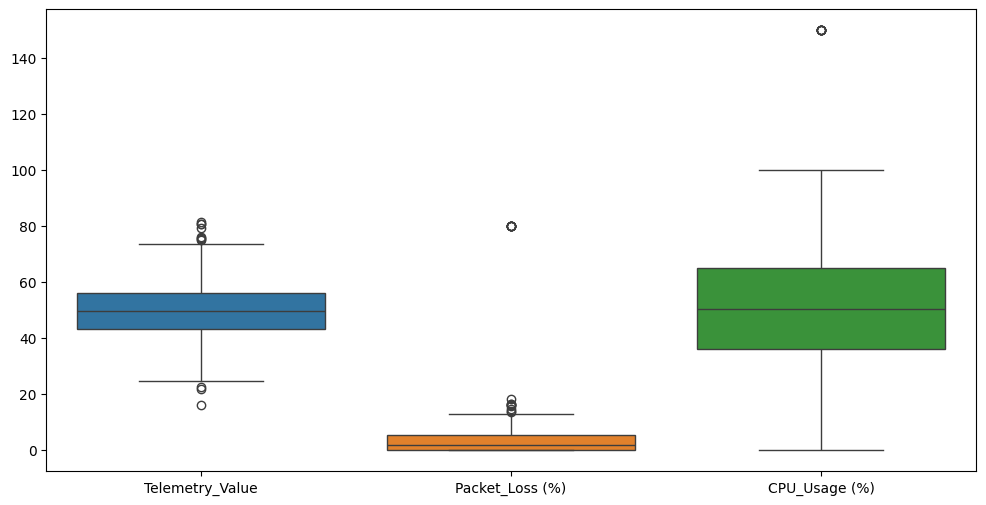

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["Telemetry_Value", "Packet_Loss (%)", "CPU_Usage (%)"]])
plt.show()


In [7]:

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df = remove_outliers(df, "Telemetry_Value")
df = remove_outliers(df, "Packet_Loss (%)")
df = remove_outliers(df, "CPU_Usage (%)")

print(f"Dataset shape after outlier removal: {df.shape}")


Dataset shape after outlier removal: (768, 13)


In [8]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["Subsystem", "Status", "Anomaly_Type"]
encoder = LabelEncoder()

for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

print(df.head())



             Timestamp  Subsystem  Sensor_ID  Telemetry_Value  Status  \
1  2025-01-01 00:01:00          1          9        43.704835       2   
4  2025-01-01 00:04:00          0         13        49.583785       0   
5  2025-01-01 00:05:00          1         28        55.560566       2   
6  2025-01-01 00:06:00          2         48        44.581009       1   
8  2025-01-01 00:08:00          0         13        49.762720       0   

   Anomaly_Type  Error_Code  Authentication_Status  Encryption_Level  \
1             1       200.0                      0               2.0   
4             2       400.0                      1               1.0   
5             2       100.0                      1               1.0   
6             1       400.0                      0               2.0   
8             2       400.0                      0               3.0   

   Packet_Loss (%)  CPU_Usage (%)  Memory_Usage (MB)  Anomaly_Label  
1         0.000000      46.851573        1331.607399      

In [9]:
print(df["Anomaly_Label"].value_counts())


Anomaly_Label
0    689
1     79
Name: count, dtype: int64


In [10]:
# Convert Timestamp to seconds since epoch
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Timestamp"] = df["Timestamp"].astype(int) // 10**9  # Convert to Unix timestamp (seconds)


In [11]:
from imblearn.over_sampling import SMOTE

X = df.drop(columns=["Anomaly_Label"])
y = df["Anomaly_Label"]

smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Before SMOTE: {y.value_counts()}")
print(f"After SMOTE: {pd.Series(y_resampled).value_counts()}")


Before SMOTE: Anomaly_Label
0    689
1     79
Name: count, dtype: int64
After SMOTE: Anomaly_Label
0    689
1    482
Name: count, dtype: int64


In [12]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Or your model

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Check class-wise precision, recall, F1-score
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.97      0.95       147
           1       0.95      0.88      0.91        88

    accuracy                           0.94       235
   macro avg       0.94      0.92      0.93       235
weighted avg       0.94      0.94      0.94       235



In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert to DataFrame and save
train_data = pd.DataFrame(X_train)
train_data["Anomaly_Label"] = y_train  # Add labels

test_data = pd.DataFrame(X_test)
test_data["Anomaly_Label"] = y_test  # Add labels

# Save to CSV
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


Training Set: (936, 12), Testing Set: (235, 12)
